In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

In [2]:
# Pulse parameters
FWHM       = 0.16   # pulse duration (ps)
pulseWL_FD = 1035   # pulse central wavelength (fundamental)(nm)
pulseWL_SH = 518    # pulse central wavelength (second harmonic)(nm)
EPP        = 2e-6   # Energy per pulse (J)
GDD        = 0.0    # Group delay dispersion (ps^2)
TOD        = 0.0    # Third order dispersion (ps^3)

# Fibre parameters
Length  = 100       # length in mm
Alpha   = 0.0       # attentuation coefficient (dB/cm)
fiber_rad = 15e-6   # radius (m)
fibWL = pulseWL_FD  # Center WL of fiber (nm)

# Xenon gas at 800nm, dispersive coefficients (betas), nonlinear refractive index (n2)
beta2 = 0.9113      # (fs^2/cm)
beta3 = 0.7836      # (fs^3/cm)
n2 = 11.15e-19      # (cm^2/W) (assumed pressure-indenpendent here)

beta2 *= (1e-3)**2/1e-5     # (ps^2/km)
beta3 *= (1e-3)**3/1e-5     # (ps^3/km)
beta4 = 0                   # (ps^4/km) (value not found)

# Gamma (1/(W km)
Gamma = ((2*np.pi)/(pulseWL_FD*1e-9)) * \
        ((n2*(1e-2)**2)/(np.pi*fiber_rad**2)) * \
        (1/1e-3)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# Simulation parameters
Window  = 10.0      # simulation window (ps)
Steps   = 50        # simulation steps
Points  = 2**13     # simulation points
Raman   = True      # Enable Raman effect?
Steep   = True      # Enable self steepening?

In [3]:
# create the fundamental pulse (repetition rate is 1 MHz)
pulse_FD = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL_FD, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=False)
pulse_FD.set_epp(EPP) # set the pulse energy

# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL_SH, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=False)
pulse_SH.set_epp(EPP)

In [4]:
# combine pulses in temporal domain
def combinePulses(pulse_lst):
    
    E_fields = [pulse.AT * np.exp(1j * pulse.W_THz * pulse.T_ps) for pulse in pulse_lst]
    E_field_combined = sum(E_fields)
    
    return E_field_combined

pulse_lst = [pulse_FD, pulse_SH]
E_field_combined = combinePulses(pulse_lst)

# create the combined pulse
pulse = pynlo.light.PulseBase.Pulse()
pulse.set_center_wavelength_nm(pulseWL_FD)
pulse.set_NPTS(Points)
pulse.set_time_window_ps(Window)
pulse.set_AT(E_field_combined)

In [5]:
# create the fiber
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)


C:\Users\shupei\anaconda3\envs\python2\lib\site-packages\jsonpickle\unpickler.py:73: UserWarning: Unpickler.on_missing must be a string or a function! It will be ignored!
  "Unpickler.on_missing must be a string or a function! It will be ignored!"


In [6]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)


Pulse energy before Simple Fiber : 4000.0000000000023 nJ
pulse energy in  989284.445374615
copied as   989284.445374615
Step: 0 Distance remaining: 0.1
Pulse energy after: 3965.8796919382057 nJ
Step: 1 Distance remaining: 0.098
Pulse energy after: 3963.610019433327 nJ
Step: 2 Distance remaining: 0.096
Pulse energy after: 3960.6704498408485 nJ
Step: 3 Distance remaining: 0.094
Pulse energy after: 3956.539538685494 nJ
Step: 4 Distance remaining: 0.092
Pulse energy after: 3950.632674489051 nJ
Step: 5 Distance remaining: 0.09
Pulse energy after: 3942.4421996863066 nJ
Step: 6 Distance remaining: 0.088
Pulse energy after: 3931.653804951361 nJ
Step: 7 Distance remaining: 0.086
Pulse energy after: 3918.214143418034 nJ
Step: 8 Distance remaining: 0.084
Pulse energy after: 3902.3383419130178 nJ
Step: 9 Distance remaining: 0.082
Pulse energy after: 3884.461213143906 nJ
Step: 10 Distance remaining: 0.08
Pulse energy after: 3865.1483335783028 nJ
Step: 11 Distance remaining: 0.078
Pulse energy after

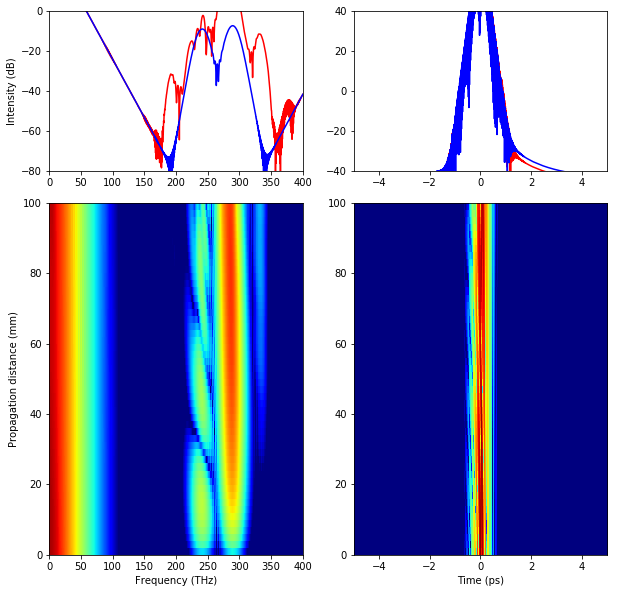

In [7]:
# plot the result
F = pulse.W_mks / (2 * np.pi) * 1e-12 # convert to THz

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y = y * 1e3 # convert distance to mm

# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

ax0.plot(F[F > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps,zT[-1], color='r')

ax0.plot(F[F > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 60.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax0.set_ylabel('Intensity (dB)')

ax2.set_xlabel('Frequency (THz)')
ax3.set_xlabel('Time (ps)')

ax2.set_ylabel('Propagation distance (mm)')

ax2.set_xlim(0,400)

ax0.set_ylim(-80,0)
ax1.set_ylim(-40,40)

plt.show()